# 1 Введение

## 1.1 Постановка задачи

**Заказчик** -- компания СИБУР  
  
**Задача** -- построить прогноз состава поступающей по трубопроводу широкой фракции легких углеводородов (ШФЛУ) на основании данных с последней перед потребителем станции подкачки  
  
**Метрика качества модели** -- MAPE  
  
**Значение метрики качества модели** -- минимальное среднее значение по всем целевым переменным

## 1.2 Исходные данные

### 1.2.1 Общее описание

На нефтехимические заводы Заказчика сырье (широкая фракция легких углеводородов - ШФЛУ) поступает по трубопроводу. Трубопровод наполняется на нескольких станциях подкачки, которые расположены последовательно на пути к потребителю.  
Состав ШФЛУ меняется на каждой станции с течением времени и, таким образом, меняется итоговый состав ШФЛУ, которую получает потребитель. Имея достоверный прогноз по составу можно оптимизировать некоторые технологические процессы.

### 1.2.2 Переданные файлы
- `train_targets.csv` - целевые переменные для тренировочного множества;
- `train_features.csv` - признаки для тренировочного множества;
- `test_features.csv` - признаки для тестового множества;
- `sample_submission.csv` - пример решения в правильном формате.

### 1.2.3 Описание данных

Данные содержат расходы сырья в т/ч для станции подкачки A (`A_rate`) и потребителя B (`B_rate`), а также массовые процентные доли различных компонент на станции A (`A_CH4`, `A_C2H6`, `A_C3H8`, `A_iC4H10`, `A_nC4H10`, `A_iC5H12`, `A_nC5H12`, `A_C6H14`).  
**Целевые переменные**: массовые процентные доли нескольких компонент на станции B (`B_C2H6`, `B_C3H8`, `B_iC4H10`, `B_nC4H10`).  
Целевые переменные для тестового периода не содержат разрывов, поэтому загружаемое решение должно содержать все временные метки из тестового множества.

## 1.3 Библиотеки и пользовательские функции

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

import lightgbm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 10
#pd.options.display.max_columns = 50
pd.options.mode.chained_assignment = None

In [9]:
def overview(df):
    '''
    Функция обзора набора данных
    '''
    
    print(df.info(), '\n')
    
    display(HTML(df.loc[:4,:].to_html()))
    
    print('\nУникальные значения:')
    for i in df.columns[1:]:
        print(i, ':', df[i].unique())
    
    print('\nПропуски:')
    for i in df.columns:
        print(i, ':', df[i].isna().sum())

In [10]:
def plots(df, col=[], rate=True, only_rate=False, index=False):
    '''
    Функция отрисовки графиков признаков
    '''
    
    if index:
        
        if rate:
            
            fig, ax = plt.subplots(figsize=(16,5))

            ax.plot(df.index, df['A_rate'], label='A_rate')
            ax.plot(df.index, df['B_rate'], label='B_rate')
            ax.legend()

            plt.show()
        
        if not only_rate:
            
            col = col

            fig, ax = plt.subplots(figsize=(16,10))

            for i in col:
                ax.plot(df.index, df[i], label=i)

            ax.legend()
            plt.show()
    
    else:
        
        if rate:
            
            fig, ax = plt.subplots(figsize=(16,5))

            ax.plot(df['timestamp'], df['A_rate'], label='A_rate')
            ax.plot(df['timestamp'], df['B_rate'], label='B_rate')
            ax.legend()

            plt.show()
            
        if not only_rate:
            
            col = col

            fig, ax = plt.subplots(figsize=(16,10))

            for i in col:
                ax.plot(df['timestamp'], df[i], label=i)

            ax.legend()
            plt.show()

Метрика MAPE расчитывается по формуле:
$$
\text{MAPE} = \frac{1}{N}\sum_{i=1}^N\frac{|y_i - \hat{y}_i|}{|y_i|}\cdot 100\%
$$ 

In [11]:
def MAPE(y, y_pred):
    '''
    Функция рассчёта MAPE
    '''
    
    return (np.sum((abs(np.array(y) - y_pred) / abs(np.array(y))), axis=0) / len(y)) * 100

In [12]:
# Словари ансамблей моделей целевых признаков

B_C2H6 = {
    # модели для расчёта начальных условий
    'ec': {'LinearRegression': {'model': LinearRegression(), 'R2': 0, 'k': 0},
           'RidgeCV': {'model': RidgeCV(alphas=(np.arange(0.1, 8, 0.1)), cv=3), 'R2': 0, 'k': 0},
           'ARDRegression': {'model': ARDRegression(), 'R2': 0, 'k': 0},
           'BayesianRidge': {'model': BayesianRidge(), 'R2': 0, 'k': 0}},
    # модели для расчёта прогноза целевого признака
    '_': {'LinearRegression': {'model': LinearRegression(), 'R2': 0, 'k': 0},
          'RidgeCV': {'model': RidgeCV(alphas=(np.arange(0.1, 8, 0.1)), cv=3), 'R2': 0, 'k': 0},
          'ARDRegression': {'model': ARDRegression(), 'R2': 0, 'k': 0},
          'BayesianRidge': {'model': BayesianRidge(), 'R2': 0, 'k': 0}}
}

B_C3H8 = {
    # модели для расчёта начальных условий
    'ec': {'LinearRegression': {'model': LinearRegression(), 'R2': 0, 'k': 0},
           'RidgeCV': {'model': RidgeCV(alphas=(np.arange(0.1, 8, 0.1)), cv=3), 'R2': 0, 'k': 0},
           'ARDRegression': {'model': ARDRegression(), 'R2': 0, 'k': 0},
           'BayesianRidge': {'model': BayesianRidge(), 'R2': 0, 'k': 0}},
    # модели для расчёта прогноза целевого признака
    '_': {'LinearRegression': {'model': LinearRegression(), 'R2': 0, 'k': 0},
          'RidgeCV': {'model': RidgeCV(alphas=(np.arange(0.1, 8, 0.1)), cv=3), 'R2': 0, 'k': 0},
          'ARDRegression': {'model': ARDRegression(), 'R2': 0, 'k': 0},
          'BayesianRidge': {'model': BayesianRidge(), 'R2': 0, 'k': 0}}
}

B_iC4H10 = {
    # модели для расчёта начальных условий
    'ec': {'LinearRegression': {'model': LinearRegression(), 'R2': 0, 'k': 0},
           'RidgeCV': {'model': RidgeCV(alphas=(np.arange(0.1, 8, 0.1)), cv=3), 'R2': 0, 'k': 0},
           'ARDRegression': {'model': ARDRegression(), 'R2': 0, 'k': 0},
           'BayesianRidge': {'model': BayesianRidge(), 'R2': 0, 'k': 0}},
    # модели для расчёта прогноза целевого признака
    '_': {'LinearRegression': {'model': LinearRegression(), 'R2': 0, 'k': 0},
          'RidgeCV': {'model': RidgeCV(alphas=(np.arange(0.1, 8, 0.1)), cv=3), 'R2': 0, 'k': 0},
          'ARDRegression': {'model': ARDRegression(), 'R2': 0, 'k': 0},
          'BayesianRidge': {'model': BayesianRidge(), 'R2': 0, 'k': 0}}
}

B_nC4H10 = {
    # модели для расчёта начальных условий
    'ec': {'LinearRegression': {'model': LinearRegression(), 'R2': 0, 'k': 0},
           'RidgeCV': {'model': RidgeCV(alphas=(np.arange(0.1, 8, 0.1)), cv=3), 'R2': 0, 'k': 0},
           'ARDRegression': {'model': ARDRegression(), 'R2': 0, 'k': 0},
           'BayesianRidge': {'model': BayesianRidge(), 'R2': 0, 'k': 0}},
    # модели для расчёта прогноза целевого признака
    '_': {'LinearRegression': {'model': LinearRegression(), 'R2': 0, 'k': 0},
          'RidgeCV': {'model': RidgeCV(alphas=(np.arange(0.1, 8, 0.1)), cv=3), 'R2': 0, 'k': 0},
          'ARDRegression': {'model': ARDRegression(), 'R2': 0, 'k': 0},
          'BayesianRidge': {'model': BayesianRidge(), 'R2': 0, 'k': 0}}
}

In [13]:
def ensamble_fit(targ, X, y, X_valid, y_valid, ec=False):
    '''
    Функция обучения моделей
    '''
    
    if ec:
        targ['ec']['LinearRegression']['model'].fit(X, y)
        targ['ec']['RidgeCV']['model'].fit(X, y)
        targ['ec']['ARDRegression']['model'].fit(X, y)
        targ['ec']['BayesianRidge']['model'].fit(X, y)
        
        targ['ec']['LinearRegression']['R2'] = targ['ec']['LinearRegression']['model'].score(X_valid, y_valid)
        targ['ec']['RidgeCV']['R2'] = targ['ec']['RidgeCV']['model'].score(X_valid, y_valid)
        targ['ec']['ARDRegression']['R2'] = targ['ec']['ARDRegression']['model'].score(X_valid, y_valid)
        targ['ec']['BayesianRidge']['R2'] = targ['ec']['BayesianRidge']['model'].score(X_valid, y_valid)
        
        S = targ['ec']['LinearRegression']['R2'] + targ['ec']['RidgeCV']['R2'] + targ['ec']['ARDRegression']['R2'] + targ['ec']['BayesianRidge']['R2']
        
        targ['ec']['LinearRegression']['k'] = targ['ec']['LinearRegression']['R2'] / S
        targ['ec']['RidgeCV']['k'] = targ['ec']['RidgeCV']['R2'] / S
        targ['ec']['ARDRegression']['k'] = targ['ec']['ARDRegression']['R2'] / S
        targ['ec']['BayesianRidge']['k'] = targ['ec']['BayesianRidge']['R2'] / S
        
    else:
        targ['_']['LinearRegression']['model'].fit(X, y)
        targ['_']['RidgeCV']['model'].fit(X, y)
        targ['_']['ARDRegression']['model'].fit(X, y)
        targ['_']['BayesianRidge']['model'].fit(X, y)
        
        targ['_']['LinearRegression']['R2'] = targ['_']['LinearRegression']['model'].score(X_valid, y_valid)
        targ['_']['RidgeCV']['R2'] = targ['_']['RidgeCV']['model'].score(X_valid, y_valid)
        targ['_']['ARDRegression']['R2'] = targ['_']['ARDRegression']['model'].score(X_valid, y_valid)
        targ['_']['BayesianRidge']['R2'] = targ['_']['BayesianRidge']['model'].score(X_valid, y_valid)
        
        S = targ['_']['LinearRegression']['R2'] + targ['_']['RidgeCV']['R2'] + targ['_']['ARDRegression']['R2'] + targ['_']['BayesianRidge']['R2']
        
        targ['_']['LinearRegression']['k'] = targ['_']['LinearRegression']['R2'] / S
        targ['_']['RidgeCV']['k'] = targ['_']['RidgeCV']['R2'] / S
        targ['_']['ARDRegression']['k'] = targ['_']['ARDRegression']['R2'] / S
        targ['_']['BayesianRidge']['k'] = targ['_']['BayesianRidge']['R2'] / S

In [14]:
def ensamble_predict(targ, X, ec=False):
    '''
    Функция получения обощенного прогноза моделей
    '''
    
    if ec:
        return (
            targ['ec']['LinearRegression']['model'].predict(X) * targ['ec']['LinearRegression']['k'] +
            targ['ec']['RidgeCV']['model'].predict(X) * targ['ec']['RidgeCV']['k'] +
            targ['ec']['ARDRegression']['model'].predict(X) * targ['ec']['ARDRegression']['k'] +
            targ['ec']['BayesianRidge']['model'].predict(X) * targ['ec']['BayesianRidge']['k'])
        
    else:
        return (
            targ['_']['LinearRegression']['model'].predict(X) * targ['_']['LinearRegression']['k'] +
            targ['_']['RidgeCV']['model'].predict(X) * targ['_']['RidgeCV']['k'] +
            targ['_']['ARDRegression']['model'].predict(X) * targ['_']['ARDRegression']['k'] +
            targ['_']['BayesianRidge']['model'].predict(X) * targ['_']['BayesianRidge']['k'])

## 1.4 Обзор данных

### 1.4.1 Таблица *train_feat*

In [15]:
sample = pd.read_csv('sample_submission.csv', parse_dates=['timestamp'])

In [16]:
overview(sample)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  3984 non-null   datetime64[ns]
 1   B_C2H6     3984 non-null   float64       
 2   B_C3H8     3984 non-null   float64       
 3   B_iC4H10   3984 non-null   float64       
 4   B_nC4H10   3984 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 155.8 KB
None 



,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-05-01 00:00:00,4.36,37.74,16.84,24.17
1,2020-05-01 00:30:00,4.36,37.74,16.84,24.17
2,2020-05-01 01:00:00,4.36,37.74,16.84,24.17
3,2020-05-01 01:30:00,4.36,37.74,16.84,24.17
4,2020-05-01 02:00:00,4.36,37.74,16.84,24.17



Уникальные значения:
B_C2H6 : [4.36370059]
B_C3H8 : [37.74275685]
B_iC4H10 : [16.8430284]
B_nC4H10 : [24.17126447]

Пропуски:
timestamp : 0
B_C2H6 : 0
B_C3H8 : 0
B_iC4H10 : 0
B_nC4H10 : 0


In [17]:
train_feat = pd.read_csv('train_features.csv', parse_dates=['timestamp'])

In [18]:
overview(train_feat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  5808 non-null   datetime64[ns]
 1   A_rate     5807 non-null   float64       
 2   A_CH4      4849 non-null   float64       
 3   A_C2H6     4849 non-null   float64       
 4   A_C3H8     4849 non-null   float64       
 5   A_iC4H10   4849 non-null   float64       
 6   A_nC4H10   4849 non-null   float64       
 7   A_iC5H12   4849 non-null   float64       
 8   A_nC5H12   4849 non-null   float64       
 9   A_C6H14    4849 non-null   float64       
 10  B_rate     5675 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 499.2 KB
None 



,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-01-01 00:00:00,70.86,nan,nan,nan,nan,nan,nan,nan,nan,71.98
1,2020-01-01 00:30:00,70.83,nan,nan,nan,nan,nan,nan,nan,nan,71.97
2,2020-01-01 01:00:00,70.81,nan,nan,nan,nan,nan,nan,nan,nan,71.87
3,2020-01-01 01:30:00,69.99,nan,nan,nan,nan,nan,nan,nan,nan,71.84
4,2020-01-01 02:00:00,70.07,nan,nan,nan,nan,nan,nan,nan,nan,71.34



Уникальные значения:
A_rate : [70.85501687 70.82658198 70.80963735 ... 71.78327257 71.71774305
 71.73032488]
A_CH4 : [       nan 0.1262443  0.1113013  ... 0.2776861  0.2711055  0.26563473]
A_C2H6 : [       nan 5.24295667 4.632455   ... 5.013878   5.08014383 5.069165  ]
A_C3H8 : [        nan 41.94148    39.19833    ... 36.27155667 36.61667333
 36.60245333]
A_iC4H10 : [        nan 17.06421333 17.440245   ... 16.50014667 16.55953333
 16.64916667]
A_nC4H10 : [        nan 23.20595333 24.33152    ... 24.01012333 24.00884833
 24.15050333]
A_iC5H12 : [       nan 4.18484767 4.615703   ... 5.829363   5.750492   5.75279167]
A_nC5H12 : [       nan 4.06207933 4.5457025  ... 5.16032933 5.01794083 4.99752767]
A_C6H14 : [       nan 4.11017    5.072316   ... 6.88417267 6.64207633 6.45913667]
B_rate : [71.9827891  71.96509827 71.86740947 ... 74.14436691 74.32057506
 74.32716963]

Пропуски:
timestamp : 0
A_rate : 1
A_CH4 : 959
A_C2H6 : 959
A_C3H8 : 959
A_iC4H10 : 959
A_nC4H10 : 959
A_iC5H12 : 959
A_nC5H

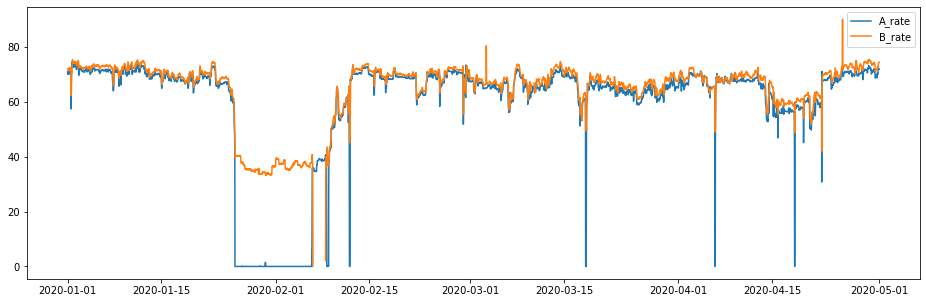

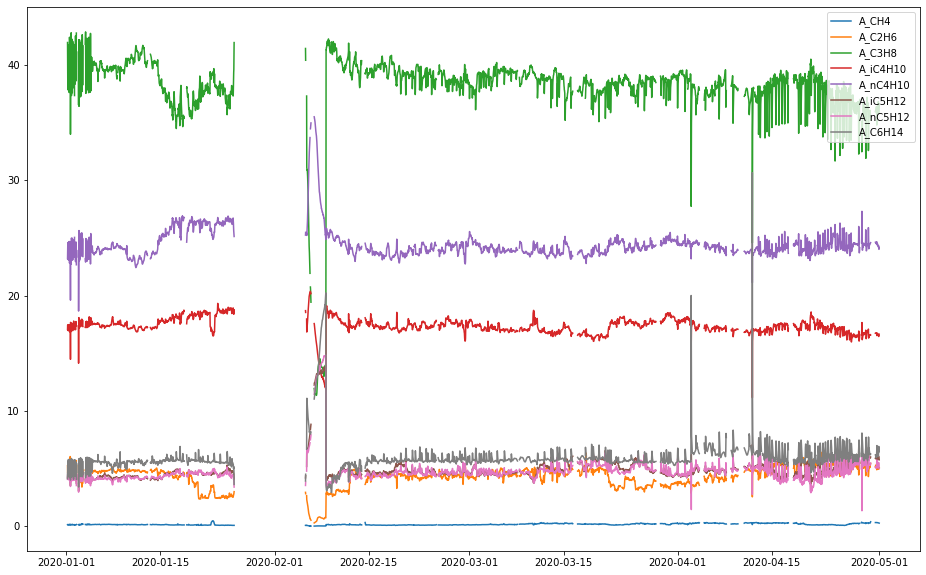

In [19]:
plots(train_feat, col=['A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14'])

### 1.4.2 Таблица *train_targ*

In [20]:
train_targ = pd.read_csv('train_targets.csv', parse_dates=['timestamp'])

In [21]:
overview(train_targ)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  5808 non-null   datetime64[ns]
 1   B_C2H6     5624 non-null   float64       
 2   B_C3H8     5628 non-null   float64       
 3   B_iC4H10   5628 non-null   float64       
 4   B_nC4H10   5628 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 227.0 KB
None 



,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-01-01 00:00:00,4.56,39.02,17.25,24.30
1,2020-01-01 00:30:00,4.55,39.05,17.23,24.26
2,2020-01-01 01:00:00,4.51,38.77,17.17,24.24
3,2020-01-01 01:30:00,4.58,39.07,17.22,24.15
4,2020-01-01 02:00:00,4.61,38.82,17.11,24.05



Уникальные значения:
B_C2H6 : [4.5619785  4.55074075 4.50679289 ... 5.101574   5.210675   5.13648675]
B_C3H8 : [39.01548625 39.048915   38.76637778 ... 36.27504    36.8729175
 35.86032625]
B_iC4H10 : [17.25074    17.22950625 17.17162111 ... 16.29546    16.33635875
 16.10150875]
B_nC4H10 : [24.3017925  24.25746125 24.23629778 ... 24.62988889 24.43823625
 24.426845  ]

Пропуски:
timestamp : 0
B_C2H6 : 184
B_C3H8 : 180
B_iC4H10 : 180
B_nC4H10 : 180


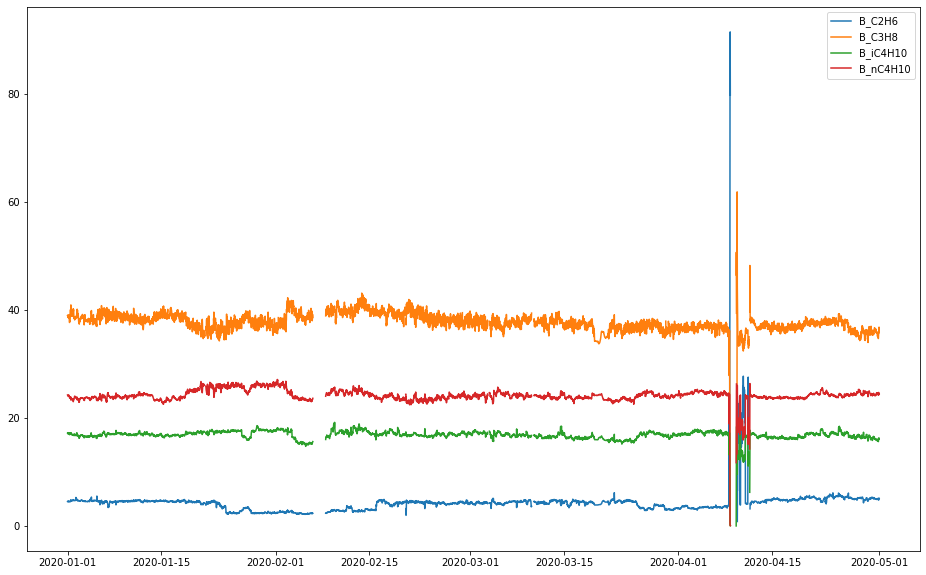

In [22]:
plots(train_targ, col=train_targ.columns[1:], rate=False)

### 1.4.3 Таблица *test_feat*

In [23]:
test_feat = pd.read_csv('test_features.csv', parse_dates=['timestamp'])

In [24]:
overview(test_feat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  3984 non-null   datetime64[ns]
 1   A_rate     2842 non-null   float64       
 2   A_CH4      3528 non-null   float64       
 3   A_C2H6     3533 non-null   float64       
 4   A_C3H8     3532 non-null   float64       
 5   A_iC4H10   3532 non-null   float64       
 6   A_nC4H10   3532 non-null   float64       
 7   A_iC5H12   3528 non-null   float64       
 8   A_nC5H12   3528 non-null   float64       
 9   A_C6H14    3529 non-null   float64       
 10  B_rate     3979 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 342.5 KB
None 



,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-05-01 00:00:00,71.43,0.27,5.14,36.82,16.63,24.06,5.70,4.94,6.40,74.27
1,2020-05-01 00:30:00,70.93,0.27,5.15,36.87,16.65,24.07,5.68,4.91,6.35,74.06
2,2020-05-01 01:00:00,70.99,0.27,5.15,37.07,16.71,24.11,5.57,4.81,6.24,73.86
3,2020-05-01 01:30:00,70.97,0.28,5.23,37.38,16.68,24.02,5.51,4.73,6.10,73.75
4,2020-05-01 02:00:00,70.98,0.28,5.24,37.45,16.66,24.00,5.52,4.73,6.06,73.70



Уникальные значения:
A_rate : [71.42834226 70.92511755 70.99171899 ... 71.80579852 72.11204551
 72.941085  ]
A_CH4 : [0.2678325  0.26846443 0.27064055 ... 0.1115354  0.11936197 0.12239275]
A_C2H6 : [5.13515867 5.149646   5.15461517 ... 4.041506   4.131432   4.2076145 ]
A_C3H8 : [36.81648    36.86902333 37.074965   ... 39.79432333 40.46150333
 40.95733   ]
A_iC4H10 : [16.63226    16.65187    16.71096667 ... 17.63538    17.75883333
 17.772225  ]
A_nC4H10 : [24.06258667 24.0698     24.10615167 ... 24.16947333 24.21101333
 24.088445  ]
A_iC5H12 : [5.696004   5.67638433 5.57487267 ... 4.61360333 4.50424167 4.3879565 ]
A_nC5H12 : [4.93943033 4.91187233 4.80851583 ... 3.79065133 3.65745867 3.536302  ]
A_C6H14 : [6.39528567 6.34695733 6.24263583 ... 5.78521567 5.09462567 4.8639655 ]
B_rate : [74.27300881 74.06183292 73.85626774 ... 74.98587819 74.76686667
 74.80466683]

Пропуски:
timestamp : 0
A_rate : 1142
A_CH4 : 456
A_C2H6 : 451
A_C3H8 : 452
A_iC4H10 : 452
A_nC4H10 : 452
A_iC5H12 : 456
A_n

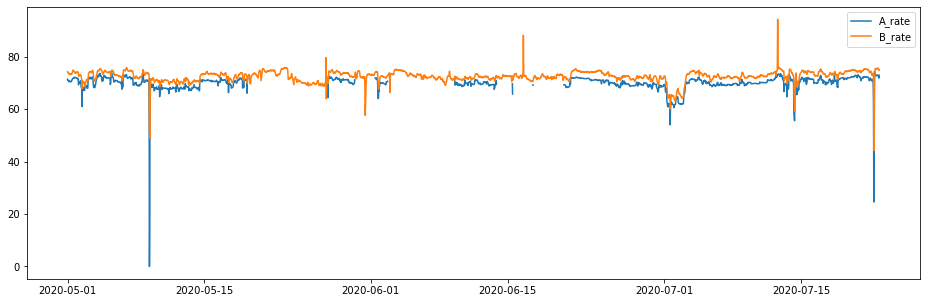

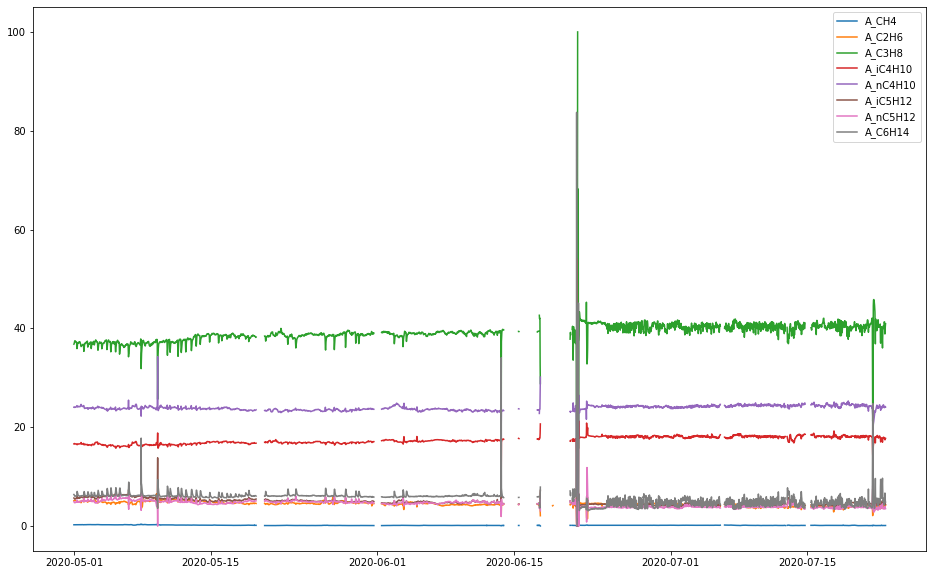

In [25]:
plots(test_feat, col=['A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14'])

По итогам первого, общего взгляда на данные, можно сделать следующие выводы:

- в наборах данных отсутствуют категориальные признаки, все признаки, кроме `timestamp` являются числовыми непрерывными;
- в наборах данных присутствуют пропуки и выбросы; пропуски необходимо заполнять методом *forward fill*, выбросы необходимо удалять только в целевых признаках;
- признак `timestamp` выполняет роль ключевого и перед обучением моделей из набора данных должен быть удалён.

# 2 Основная часть

## 2.1 Предобработка данных

### 2.1.1 Таблица *train_feat*

**Обнаружение и удаление пропусков**

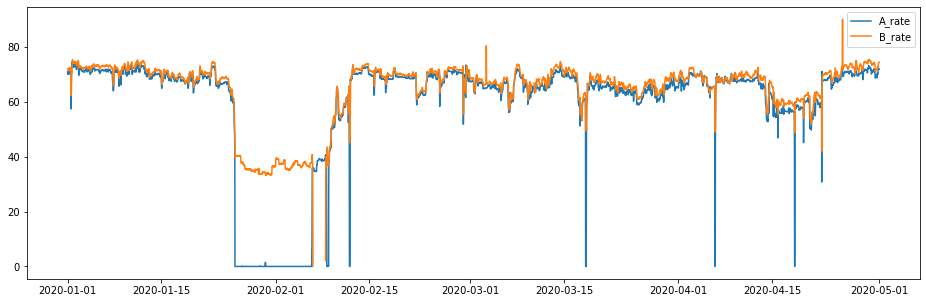

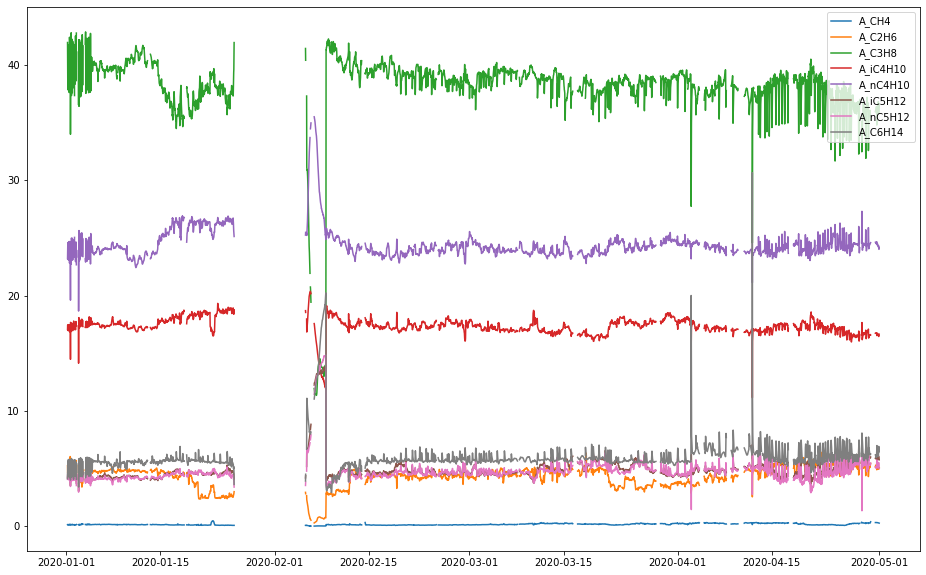

In [26]:
plots(train_feat, col=['A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14'])

In [27]:
train_feat.fillna(method='ffill', inplace=True)
train_feat.isna().sum().sum()

72

In [28]:
train_feat.loc[train_feat['A_CH4'].isna()]

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-01-01 00:00:00,70.86,nan,nan,nan,nan,nan,nan,nan,nan,71.98
1,2020-01-01 00:30:00,70.83,nan,nan,nan,nan,nan,nan,nan,nan,71.97
2,2020-01-01 01:00:00,70.81,nan,nan,nan,nan,nan,nan,nan,nan,71.87
3,2020-01-01 01:30:00,69.99,nan,nan,nan,nan,nan,nan,nan,nan,71.84
4,2020-01-01 02:00:00,70.07,nan,nan,nan,nan,nan,nan,nan,nan,71.34
5,2020-01-01 02:30:00,70.00,nan,nan,nan,nan,nan,nan,nan,nan,71.32
6,2020-01-01 03:00:00,69.93,nan,nan,nan,nan,nan,nan,nan,nan,71.16
7,2020-01-01 03:30:00,70.29,nan,nan,nan,nan,nan,nan,nan,nan,71.11
8,2020-01-01 04:00:00,70.52,nan,nan,nan,nan,nan,nan,nan,nan,71.22


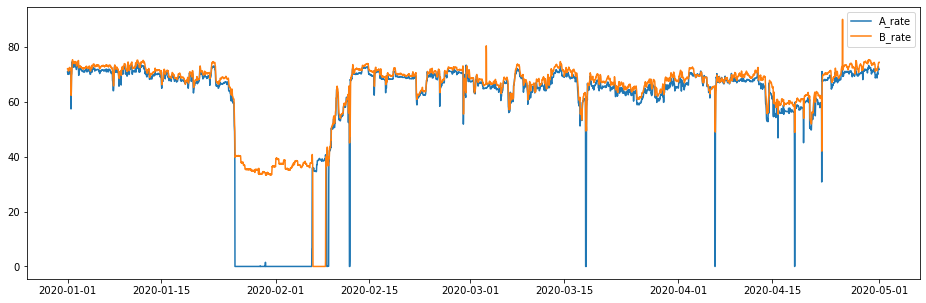

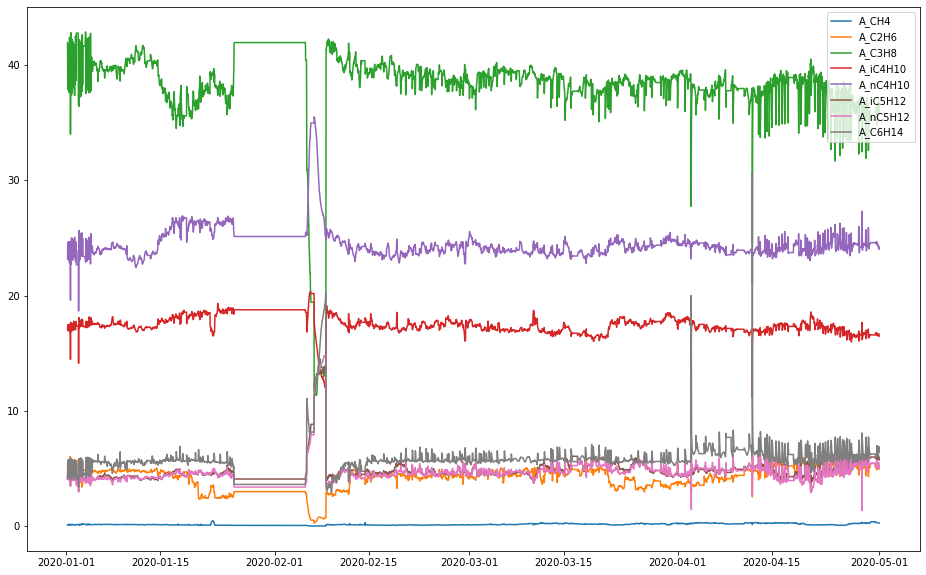

In [29]:
plots(train_feat, col=['A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14'])

### 2.1.2 Таблица *train_targ*

**Обнаружение и удаление пропусков**

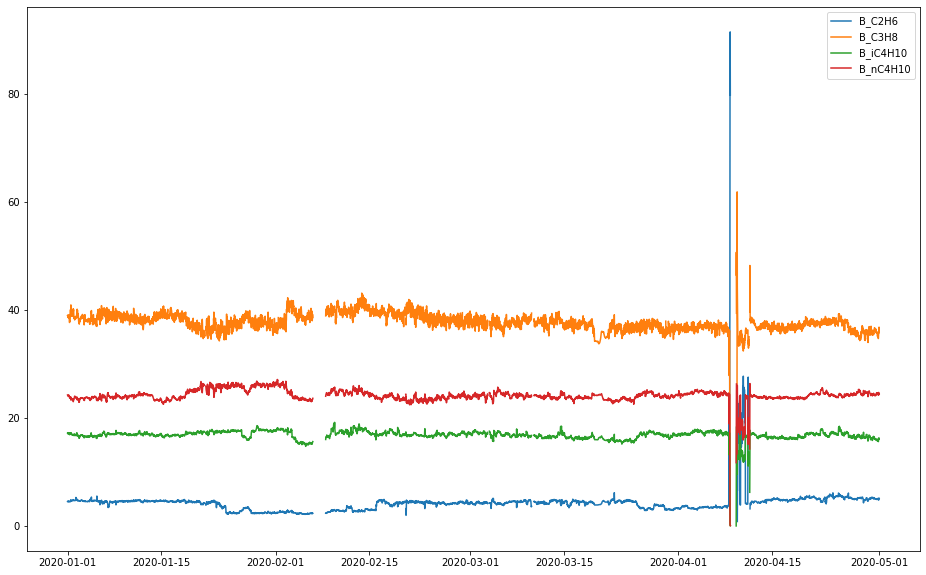

In [30]:
plots(train_targ, col=train_targ.columns[1:], rate=False)

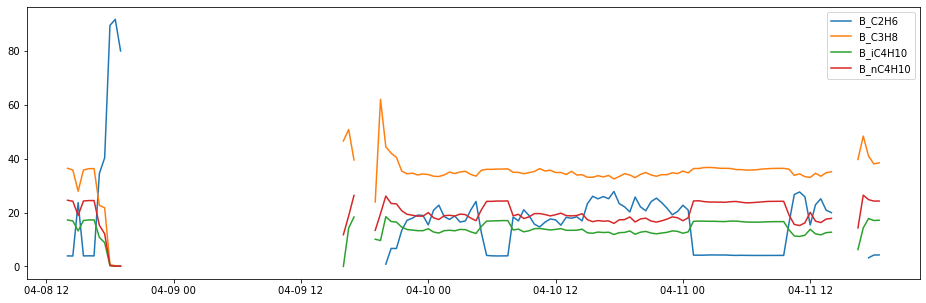

In [31]:
dts = train_targ.loc[(train_feat['timestamp'] > pd.to_datetime('2020-04-08 13:30:00')) & (train_targ['timestamp'] < pd.to_datetime('2020-04-11 19:00:00')), 'timestamp']

fig, ax = plt.subplots(figsize=(16,5))

ax.plot(dts, train_targ.loc[train_targ['timestamp'].isin(dts), 'B_C2H6'], label='B_C2H6')
ax.plot(dts, train_targ.loc[train_targ['timestamp'].isin(dts), 'B_C3H8'], label='B_C3H8')
ax.plot(dts, train_targ.loc[train_targ['timestamp'].isin(dts), 'B_iC4H10'], label='B_iC4H10')
ax.plot(dts, train_targ.loc[train_targ['timestamp'].isin(dts), 'B_nC4H10'], label='B_nC4H10')
ax.legend()

plt.show()

In [32]:
train_targ.loc[(train_feat['timestamp'] > pd.to_datetime('2020-04-08 13:30:00')) & (train_feat['timestamp'] < pd.to_datetime('2020-04-08 16:30:00')), ['timestamp', 'B_C2H6']]

,timestamp,B_C2H6
4732,2020-04-08 14:00:00,3.92
4733,2020-04-08 14:30:00,3.88
4734,2020-04-08 15:00:00,23.66
4735,2020-04-08 15:30:00,3.92
4736,2020-04-08 16:00:00,3.95


In [33]:
train_targ.loc[(train_feat['timestamp'] > pd.to_datetime('2020-04-11 15:00:00')) & (train_feat['timestamp'] < pd.to_datetime('2020-04-11 20:00:00')), ['timestamp', 'B_C3H8']]

,timestamp,B_C3H8
4879,2020-04-11 15:30:00,nan
4880,2020-04-11 16:00:00,nan
4881,2020-04-11 16:30:00,39.66
4882,2020-04-11 17:00:00,48.30
4883,2020-04-11 17:30:00,40.92
4884,2020-04-11 18:00:00,38.01
4885,2020-04-11 18:30:00,38.40
4886,2020-04-11 19:00:00,38.10
4887,2020-04-11 19:30:00,38.16


Участок данных с `2020-04-08 14:30:00` по `2020-04-11 18:00:00` имеет явные выбросы и пропуски. В целевом признаке подобные явления недопустимы, поэтому данный участок данных из наборов будет удален

In [34]:
dts = train_targ.loc[(train_targ['timestamp'] <= pd.to_datetime('2020-04-08 14:30:00')) | (train_targ['timestamp'] >= pd.to_datetime('2020-04-11 18:00:00')), 'timestamp']

train_feat_cut = train_feat.loc[train_feat['timestamp'].isin(dts), :]
train_feat_cut.reset_index(inplace=True, drop=True)

train_targ_cut = train_targ.loc[train_targ['timestamp'].isin(dts), :]
train_targ_cut.reset_index(inplace=True, drop=True)

In [35]:
train_targ_cut.fillna(method='ffill', inplace=True)
train_targ_cut.isna().sum().sum()

0

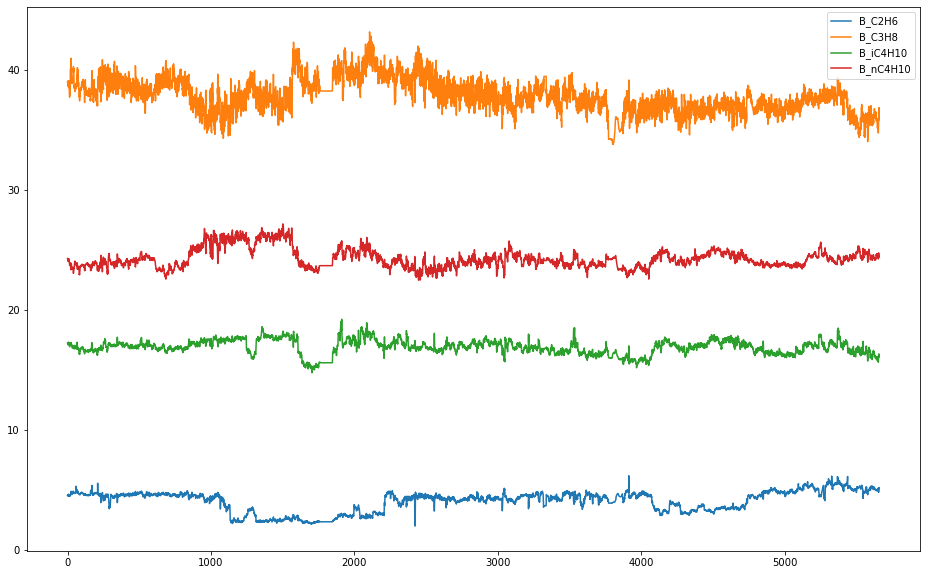

In [36]:
plots(train_targ_cut, col=train_targ_cut.columns[1:], rate=False, index=True)

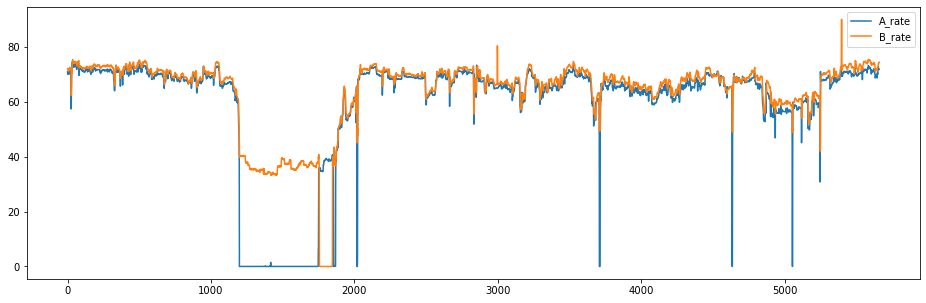

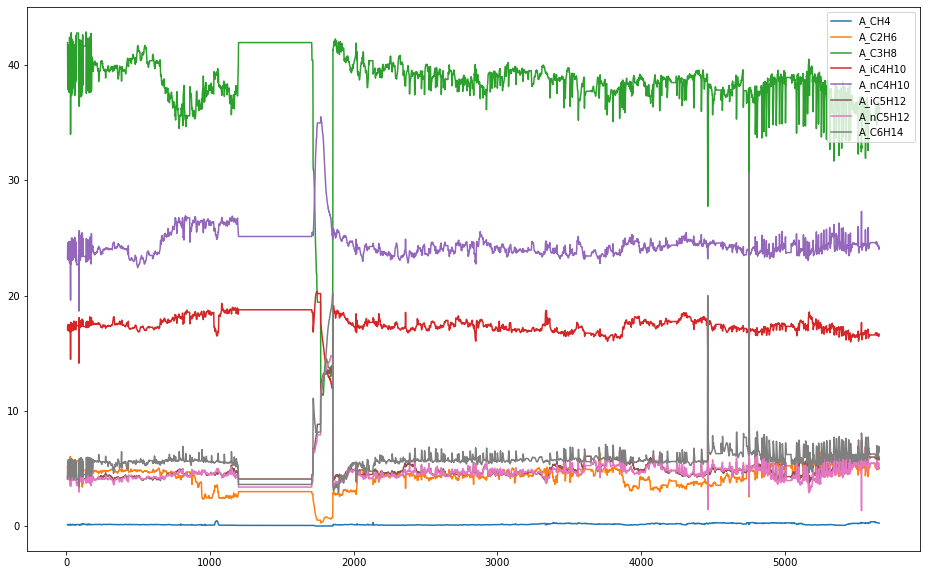

In [37]:
plots(train_feat_cut, col=['A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14'], index=True)

### 2.1.3 Таблица *test_feat*

**Обнаружение и удаление пропусков**

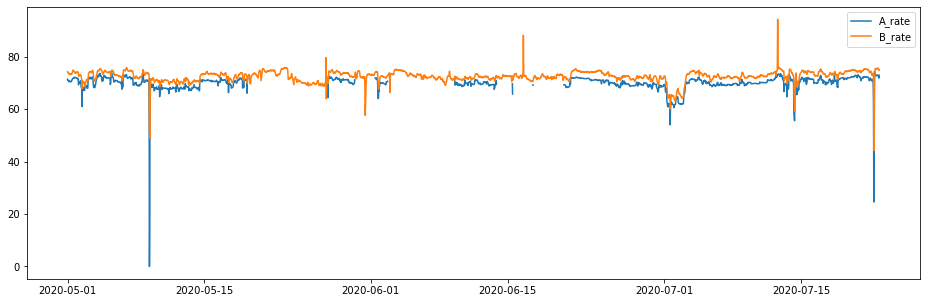

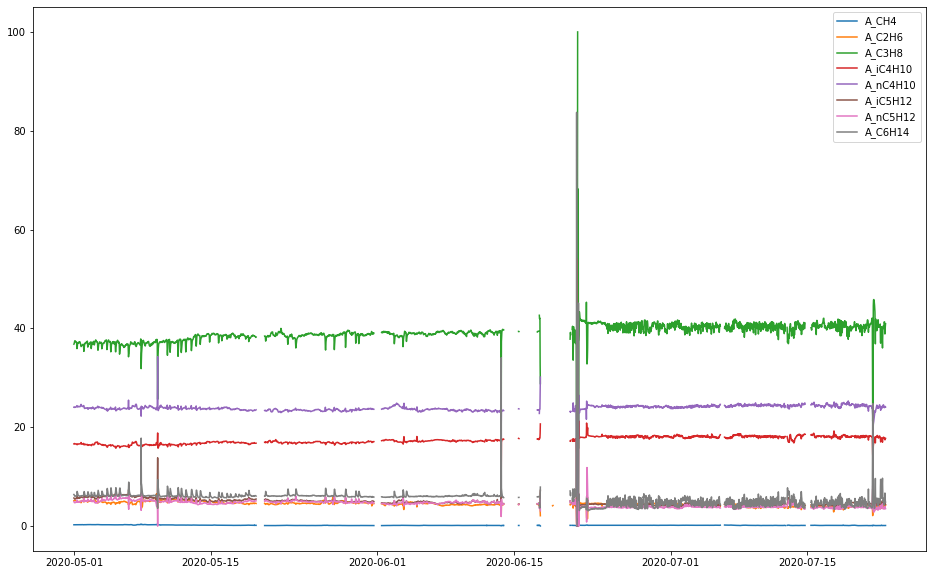

In [38]:
plots(test_feat, col=['A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14'])

In [39]:
test_feat.fillna(method='ffill', inplace=True)
test_feat.isna().sum().sum()

0

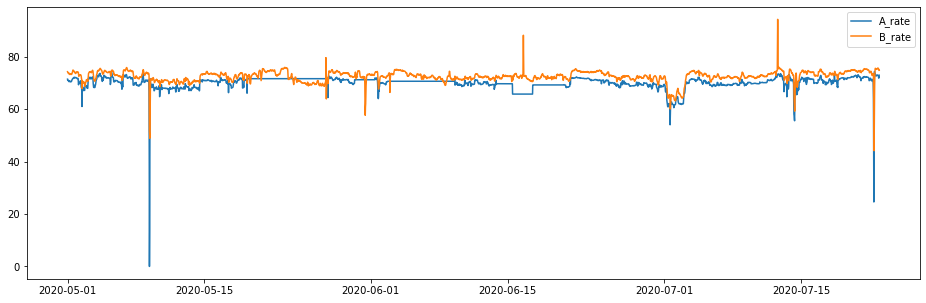

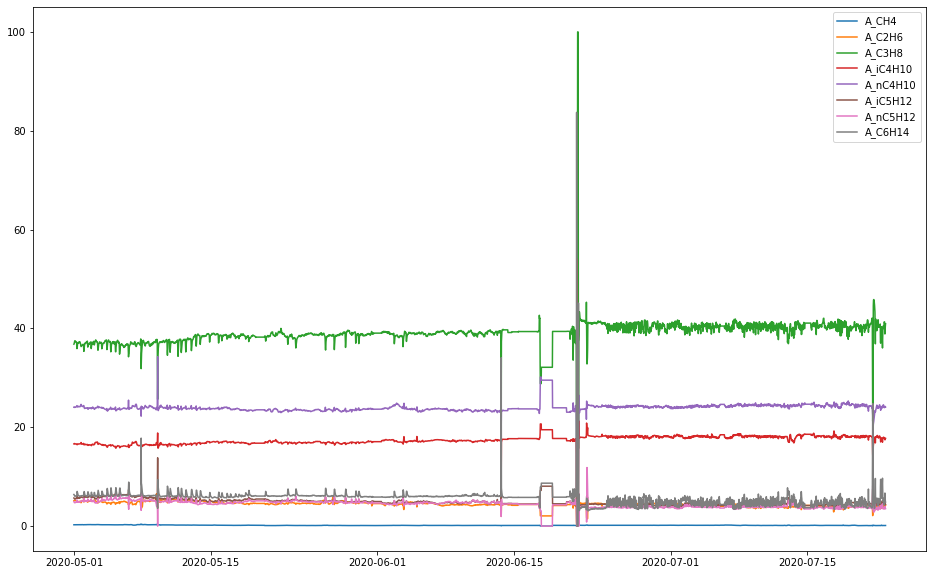

In [40]:
plots(test_feat, col=['A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14'])

## 2.2 Анализ данных

In [41]:
merge_feats = train_feat_cut.merge(train_targ_cut, on='timestamp')

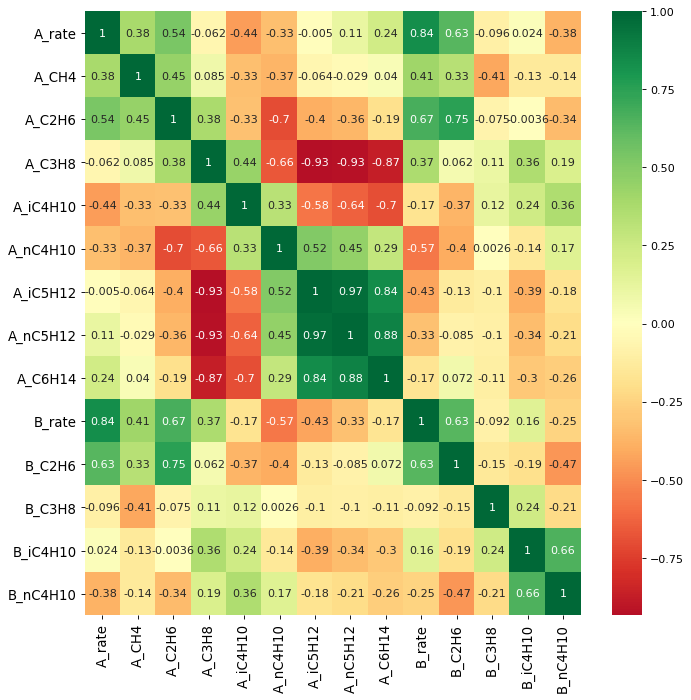

In [42]:
plt.figure(figsize=(10,10), dpi= 80)
sns.heatmap(merge_feats.corr(),
            xticklabels=merge_feats.corr().columns, 
            yticklabels=merge_feats.corr().columns, cmap='RdYlGn', center=0, annot=True)

#plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Эксперименты показали, что удаление мультиколлениарных признаков не улучшало качество прогноза, кроме признака `A_rate`, который из итогового набора данных будет удалён

## 2.3 Построение модели

**Теоретическое отсупление**

Непрерывные технологические процессы описываются типовыми динамическими звеньями, которые, в свою очередь, описываются обыкновенными диф.уравнениями (ОДУ) первого или второго порядка.  Например, А-звено второго опрядка описывается следующим ОДУ:
$$
T_{o2}^2{\cdot}\frac{d^2y(t)}{dt^2} + T_{o1}{\cdot}\frac{dy(t)}{dt} + y(t) = k{\cdot}x(t)
$$
где  $x(t)$  - входной сигнал,  $y(t)$  - выходной сигнал,  $k$  - коэффициент пропорциональности звена, $T_{o1},\;T_{o2}$  - постоянные времени звена.  
  
Интегральня кривая А2-звена при единичном ступенчатом возмущении (функцией Хевисайда, $x(t)\,=\,H(t)$) при определённых значениях $T_{o2},\,T_{o1},\,k$ может иметь вид:

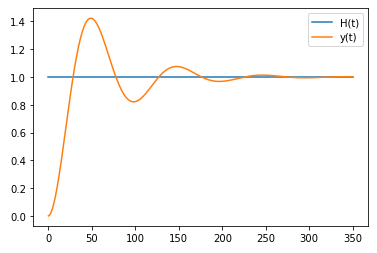

На практике данные о технологических параметрах не являются непрерывными функциями -- их значения фиксируются в определённые, дискретные моменты времени. В этом случае они имеют характер *решётчатых* функций.  
В случае решётчатых функций ОДУ А2-звена будет описано с использованием разностных уравнений -- аналогов дифференциалов непрерывных функций:
$$
T_{o2}^2{\cdot}\frac{{\bigtriangledown}^2y[nh_{p}]}{h^2_p} + T_{o1}{\cdot}\frac{{\bigtriangledown}y[nh_{p}]}{h_p} + y[nh_{p}] = k{\cdot}x[nh_{p}]
$$
где $x(t)$  - входной сигнал,  $y(t)$  - выходной сигнал, ${\bigtriangledown}^iy$ - i-ая обратная разность выходного сигнала, $n$ - номер значения решётчатой функции, $h_p$ - шаг решетки (шаг дискредизации),   $k$  - коэффициент пропорциональности звена, $T_{o1},\;T_{o2}$  - постоянные времени звена.  
  
Обозначим $y[nh_{p}] = y[n] = y_n,\,\,x[nh_{p}] = x[n] = x_n$, тогда
$$
T_{o2}^2{\cdot}\frac{{\bigtriangledown}^2y_n}{h^2_p} + T_{o1}{\cdot}\frac{{\bigtriangledown}y_n}{h_p} + y_n = k{\cdot}x_n\\
T_{o2}^2{\cdot}\left(\frac{y_n - 2{\cdot}y_{n-1} + y_{n-2}}{h^2_p}\right) + T_{o1}{\cdot}\left(\frac{y_n - y_{n-1}}{h_P}\right) + y_n = k{\cdot}x_n\\
\frac{T_{o2}^2}{h^2_p}{\cdot}y_n - \frac{2T_{o2}^2}{h^2_p}{\cdot}y_{n-1} + \frac{T_{o2}^2}{h^2_p}{\cdot}y_{n-2} + \frac{T_{o1}}{h_P}{\cdot}y_n - \frac{T_{o1}}{h_P}{\cdot}y_{n-1} + y_n = k{\cdot}x_n\\
\left(\frac{T_{o2}^2}{h^2_p} + \frac{T_{o1}}{h_P} + 1\right){\cdot}y_n - \left(\frac{2T_{o2}^2}{h^2_p} + \frac{T_{o1}}{h_P}\right){\cdot}y_{n-1} + \frac{T_{o2}^2}{h^2_p}{\cdot}y_{n-2} = k{\cdot}x_n\\
\boxed{y_n = C_1{\cdot}x_n + C_2{\cdot}y_{n-1} - C_3{\cdot}y_{n-2}},\,C_1 = \frac{k}{\left(\frac{T_{o2}^2}{h^2_p} + \frac{T_{o1}}{h_P} + 1\right)},\,C_2 = \frac{\left(\frac{2T_{o2}^2}{h^2_p} + \frac{T_{o1}}{h_P}\right)}{\left(\frac{T_{o2}^2}{h^2_p} + \frac{T_{o1}}{h_P} + 1\right)},\,C_3 = \frac{\frac{T_{o2}^2}{h^2_p}}{\left(\frac{T_{o2}^2}{h^2_p} + \frac{T_{o1}}{h_P} + 1\right)}
$$

Учитывая динамические харакетрстики целевых признаков, их прогнозируемое значение будет иметь вид:  
  
$$
y_n = C_{1_1}{\cdot}x_{n_1} +\,{\cdots}\,+ C_{1_m}{\cdot}x_{n_m} + C_2{\cdot}y_{n-1} - C_3{\cdot}y_{n-2}
$$
  
где $y_n$ - прогнозируемое значение целевого признака, $x_{n_i}$ - значение признака набора данных, $y_{n-1},\,y_{n-2}$ - последнее и предпоследнее значения целевого признака.  
  
Отсюда видно, что данная рекурентная формула является линейной, что даёт возможность применять ML-модели линейной регресии

**Подготовка наборов**

In [43]:
# Порядок ОДУ

p = 5

In [44]:
train_feat_cut.drop(columns=['timestamp', 'A_rate'], inplace=True)

In [45]:
train_feat_cut = train_feat_cut.loc[9:]
train_feat_cut.reset_index(drop=True, inplace=True)

In [46]:
train_targ_cut = train_targ_cut.loc[9-p:]
train_targ_cut.reset_index(drop=True, inplace=True)

In [47]:
B_C2H6_feats = train_feat_cut.copy()
B_C3H8_feats = train_feat_cut.copy()
B_iC4H10_feats = train_feat_cut.copy()
B_nC4H10_feats = train_feat_cut.copy()

In [48]:
B_C2H6_feats

,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,0.13,5.24,41.94,17.06,23.21,4.18,4.06,4.11,71.39
1,0.11,4.63,39.20,17.44,24.33,4.62,4.55,5.07,71.79
2,0.13,4.73,37.87,17.35,24.57,4.85,4.82,5.63,71.94
3,0.14,5.21,39.76,17.10,23.76,4.51,4.43,5.02,72.12
4,0.14,5.44,41.62,16.96,23.12,4.21,4.09,4.35,72.28
...,...,...,...,...,...,...,...,...,...
5644,0.28,4.94,35.76,16.47,24.32,6.07,5.53,6.58,74.18
5645,0.28,4.96,35.88,16.45,24.07,5.98,5.41,6.92,74.21
5646,0.28,5.01,36.27,16.50,24.01,5.83,5.16,6.88,74.14
5647,0.27,5.08,36.62,16.56,24.01,5.75,5.02,6.64,74.32


In [49]:
# Дополнение наборов признаками, необходимых для расчёта производных

for i in range(len(B_C2H6_feats)-p):
    
    for j in range(p):
        
        B_C2H6_feats.loc[i, 'yn_'+str(p-j)] = train_targ_cut.loc[i+j, 'B_C2H6']
        B_C3H8_feats.loc[i, 'yn_'+str(p-j)] = train_targ_cut.loc[i+j, 'B_C3H8']
        B_iC4H10_feats.loc[i, 'yn_'+str(p-j)] = train_targ_cut.loc[i+j, 'B_iC4H10']
        B_nC4H10_feats.loc[i, 'yn_'+str(p-j)] = train_targ_cut.loc[i+j, 'B_nC4H10']
        
    B_C2H6_feats.loc[i, 'yn'] = train_targ_cut.loc[i+p, 'B_C2H6']
    B_C3H8_feats.loc[i, 'yn'] = train_targ_cut.loc[i+p, 'B_C3H8']
    B_iC4H10_feats.loc[i, 'yn'] = train_targ_cut.loc[i+p, 'B_iC4H10']
    B_nC4H10_feats.loc[i, 'yn'] = train_targ_cut.loc[i+p, 'B_nC4H10']

In [50]:
B_C2H6_feats = B_C2H6_feats.loc[:B_C2H6_feats.shape[0]-p-1]
B_C3H8_feats = B_C3H8_feats.loc[:B_C3H8_feats.shape[0]-p-1]
B_iC4H10_feats = B_iC4H10_feats.loc[:B_iC4H10_feats.shape[0]-p-1]
B_nC4H10_feats = B_nC4H10_feats.loc[:B_nC4H10_feats.shape[0]-p-1]

In [51]:
B_C2H6_train_f, B_C2H6_valid_f = train_test_split(B_C2H6_feats, shuffle=False, test_size=0.25, random_state=1456)
B_C3H8_train_f, B_C3H8_valid_f = train_test_split(B_C3H8_feats, shuffle=False, test_size=0.25, random_state=1456)
B_iC4H10_train_f, B_iC4H10_valid_f = train_test_split(B_iC4H10_feats, shuffle=False, test_size=0.25, random_state=1456)
B_nC4H10_train_f, B_nC4H10_valid_f = train_test_split(B_nC4H10_feats, shuffle=False, test_size=0.25, random_state=1456)

In [52]:
B_C2H6_train_f.loc[:, train_feat_cut.columns]

,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,0.13,5.24,41.94,17.06,23.21,4.18,4.06,4.11,71.39
1,0.11,4.63,39.20,17.44,24.33,4.62,4.55,5.07,71.79
2,0.13,4.73,37.87,17.35,24.57,4.85,4.82,5.63,71.94
3,0.14,5.21,39.76,17.10,23.76,4.51,4.43,5.02,72.12
4,0.14,5.44,41.62,16.96,23.12,4.21,4.09,4.35,72.28
...,...,...,...,...,...,...,...,...,...
4228,0.20,3.92,38.47,17.74,24.37,4.82,4.84,5.61,63.54
4229,0.20,3.92,38.47,17.74,24.37,4.82,4.84,5.61,63.74
4230,0.20,3.92,38.47,17.74,24.37,4.82,4.84,5.61,63.86
4231,0.20,3.92,38.47,17.74,24.37,4.82,4.84,5.61,63.78


In [53]:
# Обучение модели для расчёта начальных условий
ensamble_fit(B_C2H6,
             B_C2H6_train_f.loc[:, train_feat_cut.columns], B_C2H6_train_f['yn'],
             B_C2H6_valid_f.loc[:, train_feat_cut.columns], B_C2H6_valid_f['yn'],
             ec=True)

# Обучение прогнозной модели
ensamble_fit(B_C2H6,
             B_C2H6_train_f.drop(columns=['yn']), B_C2H6_train_f['yn'],
             B_C2H6_valid_f.drop(columns=['yn']), B_C2H6_valid_f['yn'])

In [54]:
# Обучение модели для расчёта начальных условий
ensamble_fit(B_C3H8,
             B_C3H8_train_f.loc[:, train_feat_cut.columns], B_C3H8_train_f['yn'],
             B_C3H8_valid_f.loc[:, train_feat_cut.columns], B_C3H8_valid_f['yn'],
             ec=True)

# Обучение прогнозной модели
ensamble_fit(B_C3H8,
             B_C3H8_train_f.drop(columns=['yn']), B_C3H8_train_f['yn'],
             B_C3H8_valid_f.drop(columns=['yn']), B_C3H8_valid_f['yn'])

In [55]:
# Обучение модели для расчёта начальных условий
ensamble_fit(B_iC4H10,
             B_iC4H10_train_f.loc[:, train_feat_cut.columns], B_iC4H10_train_f['yn'],
             B_iC4H10_valid_f.loc[:, train_feat_cut.columns], B_iC4H10_valid_f['yn'],
             ec=True)

# Обучение прогнозной модели
ensamble_fit(B_iC4H10,
             B_iC4H10_train_f.drop(columns=['yn']), B_iC4H10_train_f['yn'],
             B_iC4H10_valid_f.drop(columns=['yn']), B_iC4H10_valid_f['yn'])

In [56]:
# Обучение модели для расчёта начальных условий
ensamble_fit(B_nC4H10,
             B_nC4H10_train_f.loc[:, train_feat_cut.columns], B_nC4H10_train_f['yn'],
             B_iC4H10_valid_f.loc[:, train_feat_cut.columns], B_iC4H10_valid_f['yn'],
             ec=True)

# Обучение прогнозной модели
ensamble_fit(B_nC4H10,
             B_nC4H10_train_f.drop(columns=['yn']), B_nC4H10_train_f['yn'],
             B_nC4H10_valid_f.drop(columns=['yn']), B_nC4H10_valid_f['yn'])

---

In [60]:
(
    MAPE(B_C2H6_valid_f['yn'], ensamble_predict(B_C2H6, B_C2H6_valid_f.drop(columns=['yn']))) + 
    MAPE(B_C3H8_valid_f['yn'], ensamble_predict(B_C3H8, B_C3H8_valid_f.drop(columns=['yn']))) + 
    MAPE(B_iC4H10_valid_f['yn'], ensamble_predict(B_iC4H10, B_iC4H10_valid_f.drop(columns=['yn']))) +
    MAPE(B_nC4H10_valid_f['yn'], ensamble_predict(B_nC4H10, B_nC4H10_valid_f.drop(columns=['yn'])))
) / 4

0.864121975966994

## 2.4 Построение прогноза

In [50]:
test_pred = test_feat.copy()
test_feat.drop(columns=['timestamp'],inplace=True)
test_pred.drop(columns=test_feat.columns, inplace=True)
test_feat.drop(columns=['A_rate'],inplace=True)

In [51]:
B_C2H6_test_feats = test_feat.copy()
B_C3H8_test_feats = test_feat.copy()
B_iC4H10_test_feats = test_feat.copy()
B_nC4H10_test_feats = test_feat.copy()

In [52]:
# Запись начальных условий

for i in range(p):
    
    B_C2H6_test_feats.loc[i, 'yn'] = ensamble_predict(B_C2H6, B_C2H6_test_feats.loc[i:i, :'B_rate'], ec=True)[0]
    B_C3H8_test_feats.loc[i, 'yn'] = ensamble_predict(B_C3H8, B_C3H8_test_feats.loc[i:i, :'B_rate'], ec=True)[0]
    B_iC4H10_test_feats.loc[i, 'yn'] = ensamble_predict(B_iC4H10, B_iC4H10_test_feats.loc[i:i, :'B_rate'], ec=True)[0]
    B_nC4H10_test_feats.loc[i, 'yn'] = ensamble_predict(B_nC4H10, B_nC4H10_test_feats.loc[i:i, :'B_rate'], ec=True)[0]

In [53]:
# Формирование предсказаний

for i in range(p, test_feat.shape[0]):
    
    for j in range(p):
        
        B_C2H6_test_feats.loc[i, 'yn_'+str(p-j)] = B_C2H6_test_feats.loc[i-p+j, 'yn']
        B_C3H8_test_feats.loc[i, 'yn_'+str(p-j)] = B_C3H8_test_feats.loc[i-p+j, 'yn']
        B_iC4H10_test_feats.loc[i, 'yn_'+str(p-j)] = B_iC4H10_test_feats.loc[i-p+j, 'yn']
        B_nC4H10_test_feats.loc[i, 'yn_'+str(p-j)] = B_nC4H10_test_feats.loc[i-p+j, 'yn']
        
    B_C2H6_test_feats.loc[i, 'yn'] = ensamble_predict(B_C2H6, B_C2H6_test_feats.loc[i:i, B_C2H6_test_feats.drop(columns=['yn']).columns])
    B_C3H8_test_feats.loc[i, 'yn'] = ensamble_predict(B_C3H8, B_C3H8_test_feats.loc[i:i, B_C3H8_test_feats.drop(columns=['yn']).columns])
    B_iC4H10_test_feats.loc[i, 'yn'] = ensamble_predict(B_iC4H10, B_iC4H10_test_feats.loc[i:i, B_iC4H10_test_feats.drop(columns=['yn']).columns])
    B_nC4H10_test_feats.loc[i, 'yn'] = ensamble_predict(B_nC4H10, B_nC4H10_test_feats.loc[i:i, B_nC4H10_test_feats.drop(columns=['yn']).columns])

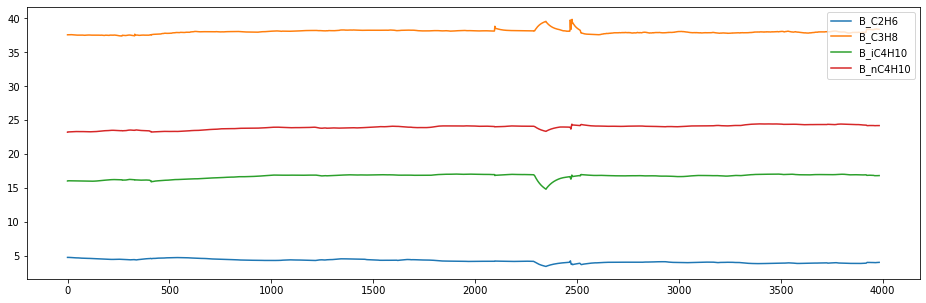

In [54]:
fig, ax = plt.subplots(figsize=(16,5))

ax.plot(B_C2H6_test_feats.index, B_C2H6_test_feats['yn'], label='B_C2H6')
ax.plot(B_C3H8_test_feats.index, B_C3H8_test_feats['yn'], label='B_C3H8')
ax.plot(B_iC4H10_test_feats.index, B_iC4H10_test_feats['yn'], label='B_iC4H10')
ax.plot(B_nC4H10_test_feats.index, B_nC4H10_test_feats['yn'], label='B_nC4H10')
ax.legend()

plt.show()

In [55]:
test_pred['B_C2H6'] = B_C2H6_test_feats['yn']
test_pred['B_C3H8'] = B_C3H8_test_feats['yn']
test_pred['B_iC4H10'] = B_iC4H10_test_feats['yn']
test_pred['B_nC4H10'] = B_nC4H10_test_feats['yn']

In [56]:
test_pred

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-05-01 00:00:00,4.79,37.60,16.05,23.24
1,2020-05-01 00:30:00,4.79,37.60,16.05,23.24
2,2020-05-01 01:00:00,4.78,37.60,16.07,23.28
3,2020-05-01 01:30:00,4.80,37.60,16.08,23.28
4,2020-05-01 02:00:00,4.79,37.60,16.08,23.28
...,...,...,...,...,...
3979,2020-07-22 21:30:00,4.05,38.40,16.85,24.22
3980,2020-07-22 22:00:00,4.06,38.42,16.85,24.21
3981,2020-07-22 22:30:00,4.06,38.42,16.85,24.22
3982,2020-07-22 23:00:00,4.06,38.41,16.85,24.22


In [ ]:
test_pred.to_csv('test_predict_0.20.csv', index=False)

In [ ]:
pred = pd.read_csv('test_predict_0.20.csv', parse_dates=['timestamp'])

In [ ]:
pred

Итоговый результат: MAPE = 3.4197

# 3 Вывод

В ходе выполнения работы было сделано следующее.  
  
По итогам обзора данных, были сделаны следующие выводы:
- в наборах данных отсутствуют категориальные признаки, все признаки, кроме `timestamp` являются числовыми непрерывными;
- в наборах данных присутствуют пропуки и выбросы; пропуски необходимо заполнять методом *forward fill*, выбросы необходимо удалять только в целевых признаках;
- признак `timestamp` выполняет роль ключевого и перед обучением моделей из набора данных должен быть удалён. 
  
На этапе предобработки данных были заполнены пропуски в данных методом *forward fill*, в тбалицах *train_feat* и *train_targ* удален участок данных с `2020-04-08 14:30:00` по `2020-04-11 18:00:00`, имеющий явные выбросы и пропуски.  
  
На этапе анализа данных признаки были проверены на мультиколлинеарность и по результатам экспериментов был сделан вывод, что удаление мультиколлениарных признаков не улучшает качество прогноза, кроме признака `A_rate`, который из итогового набора данных был впоследствии удалён.   
  
На этапе построения модели обучающий набор данных был дополнен признаками, необходимыми для расчёта производных, наборы данных были разделены на обучающие и валидационные. Затем на подготовленных на предыдущих этапах данных были обучены модели для расчёта начальных условий и прогнозные модели.  
  
На этапе построения прогноза были применены модели, полученные на предыдущем этапе, которые сформировали прогнозы целевых признаков. Предложенный подход показал наилучшее значение MAPE.
  
***Таким образом, прогнозирование значений состава ШФЛУ рекомендовано выполнять ансамблем линейных моделей машинного обучения с предварительным дополнением наборов данных признаками, необходимыми для расчёта производных целевых признаков***